In [1]:
import pydicom
import scipy
from scipy.optimize import least_squares, minimize

from data_structures.ct_image import CTImage
from utils import *

In [2]:
reference_image_path = "data_2/Project/icbm_avg_152_t1_tal_nlin_symmetric_VI.dcm"
patient_image_path = "data_2/Project/RM_Brain_3D-SPGR/"

In [3]:
reference_image = pydicom.dcmread(reference_image_path)
reference_image.pixel_array.shape

(193, 229, 193)

In [4]:
reference_image

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 246
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Multi-frame Grayscale Byte Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.2.1125.1.75016478533424131876166250616878576
(0002, 0010) Transfer Syntax UID                 UI: JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.2.1143.107.104.103.115.2.8.5.126.124.113
(0002, 0013) Implementation Version Name         SH: 'MIIO 1'
(0002, 0016) Source Application Entity Title     AE: 'MIIO'
-------------------------------------------------
(0008, 0016) SOP Class UID                       UI: Multi-frame Grayscale Byte Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.8

In [5]:
# Access the Shared Functional Groups Sequence
shared_functional_groups_sequence = reference_image.get((0x5200, 0x9229), None)

if shared_functional_groups_sequence:

    for item in shared_functional_groups_sequence:
        pixel_measures_sequence = item.get((0x0028, 0x9110), None)

        if pixel_measures_sequence:
            pixel_spacing = pixel_measures_sequence[0].get((0x0028, 0x0030), None)
            print("Pixel Spacing:", pixel_spacing)

Pixel Spacing: (0028, 0030) Pixel Spacing                       DS: [1, 1]


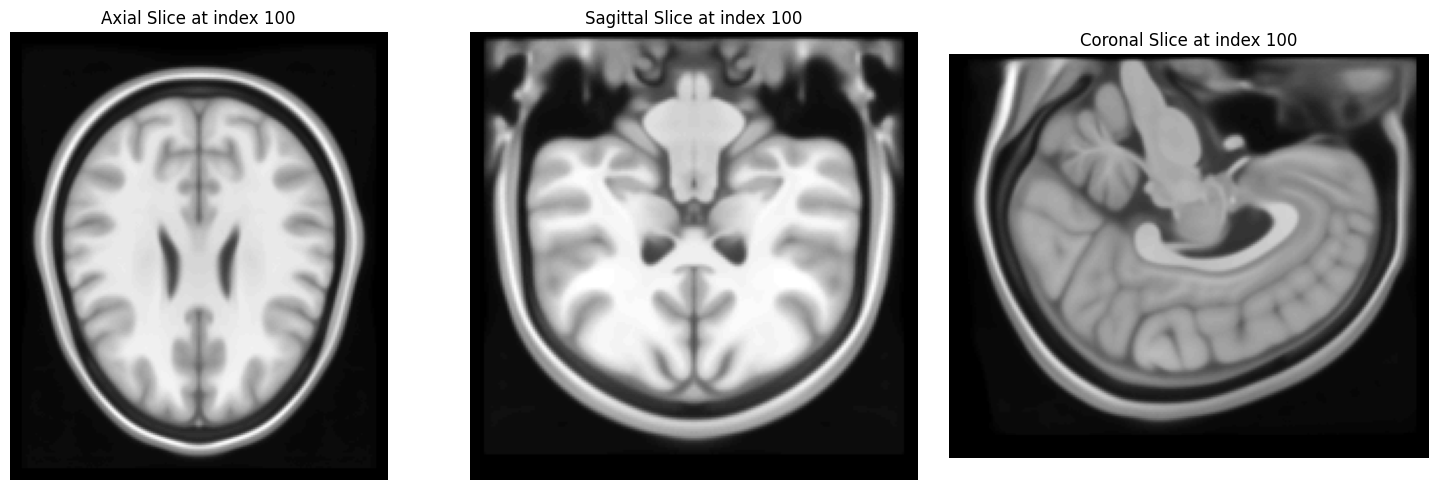

In [6]:
visualize_slices(reference_image.pixel_array, 100, 100, 100)

In [7]:
patient_image = CTImage()
patient_image.load_data(patient_image_path)
patient_image.make_3d_array()

In [8]:
patient_image.pixel_array.shape

(212, 512, 512)

In [9]:
patient_image.resize_image(reference_image.pixel_array.shape)

In [10]:
patient_image.pixel_array.shape

(193, 229, 193)

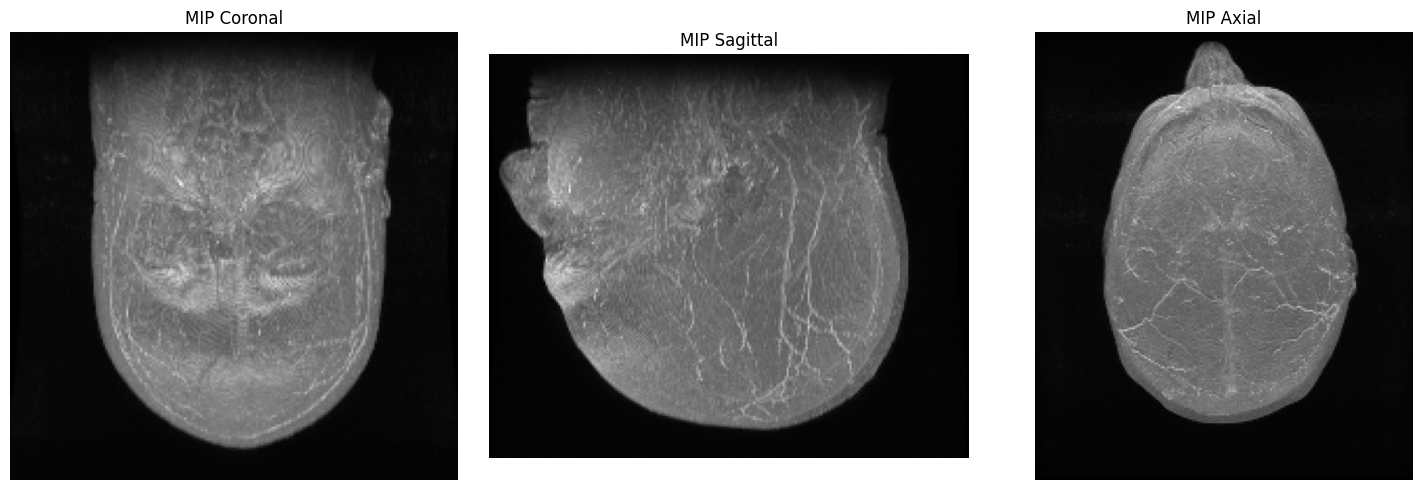

In [11]:
patient_image.visualize_all_projections_mip()

(193, 229, 193)


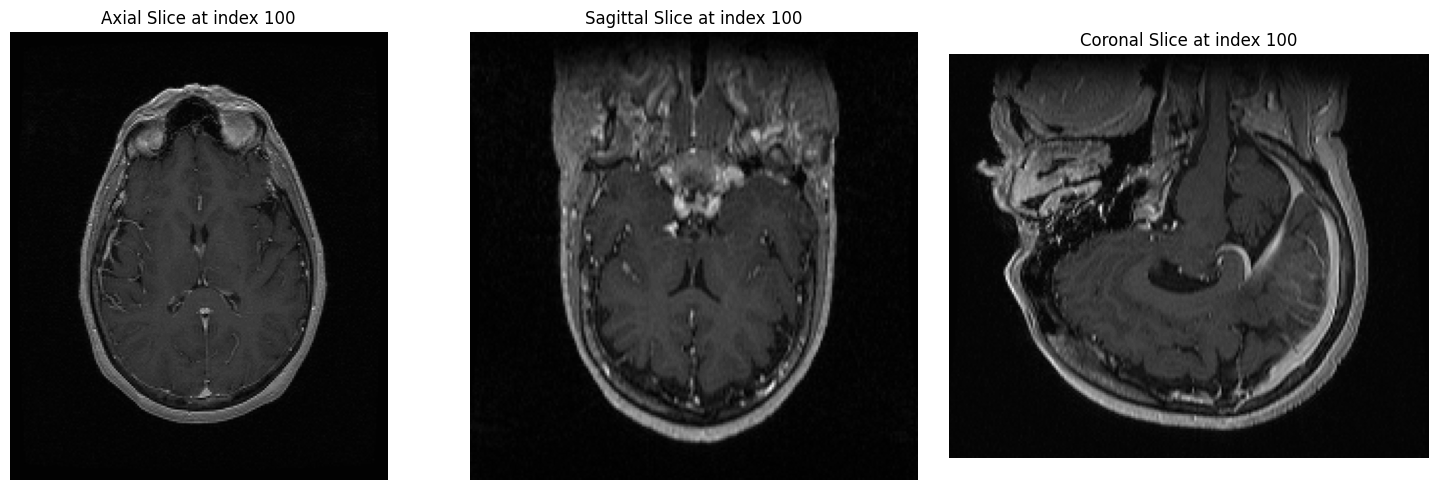

In [12]:
print(patient_image.pixel_array.shape)
patient_image.visualize_slices(100, 100, 100)

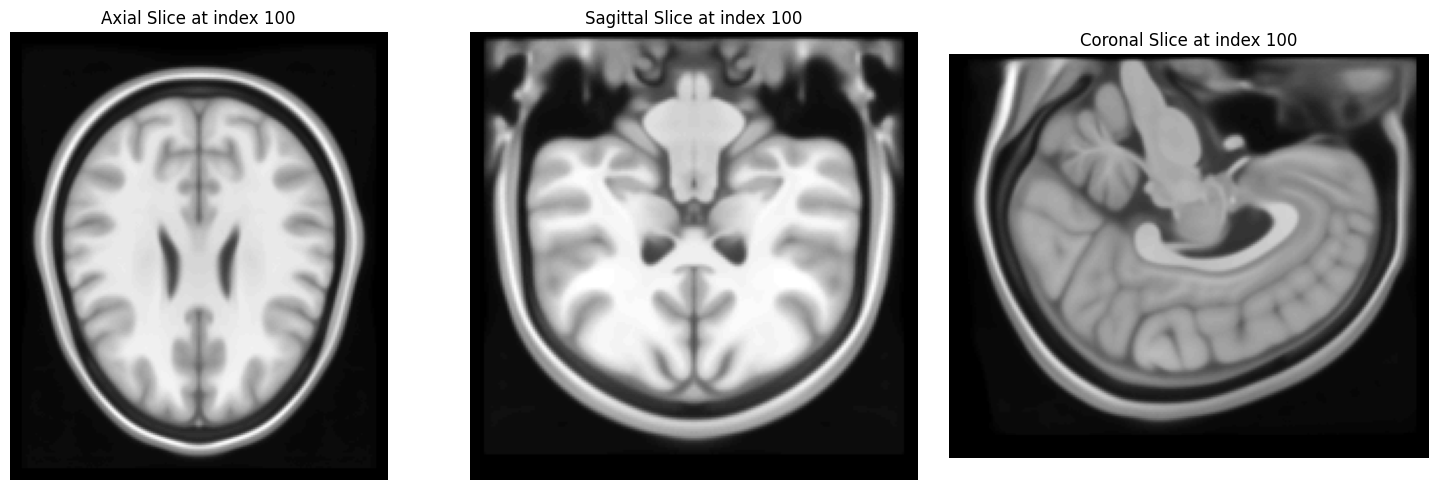

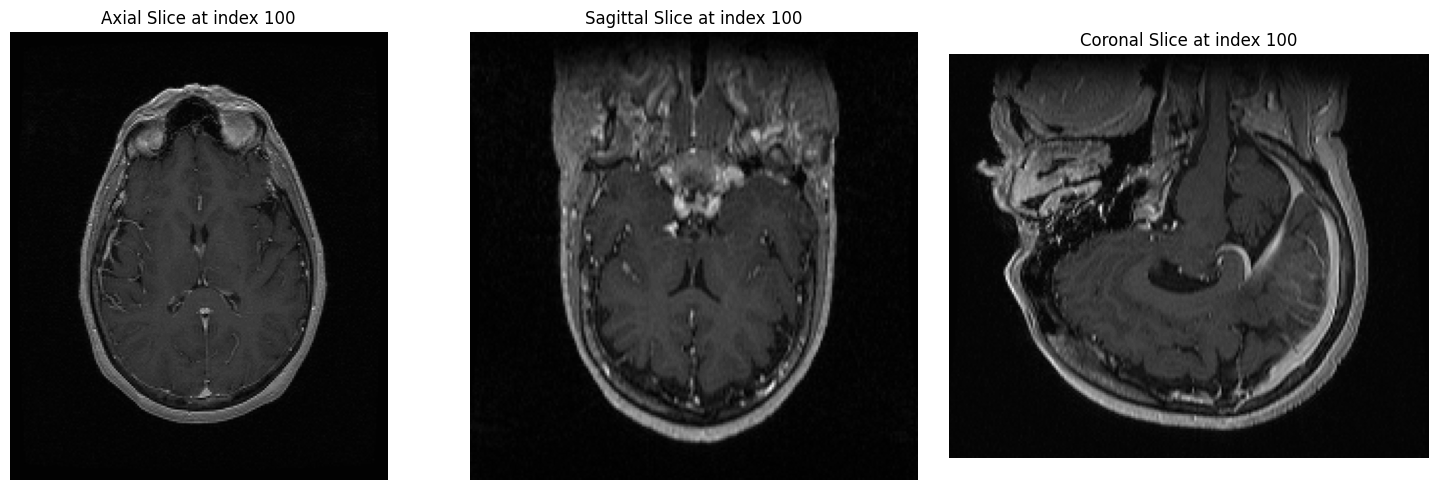

In [13]:
visualize_slices(reference_image.pixel_array, 100, 100, 100)
patient_image.visualize_slices(100, 100, 100)

In [14]:
# patient_image.pixel_array = rotate_on_axial_plane(patient_image.pixel_array, 180)

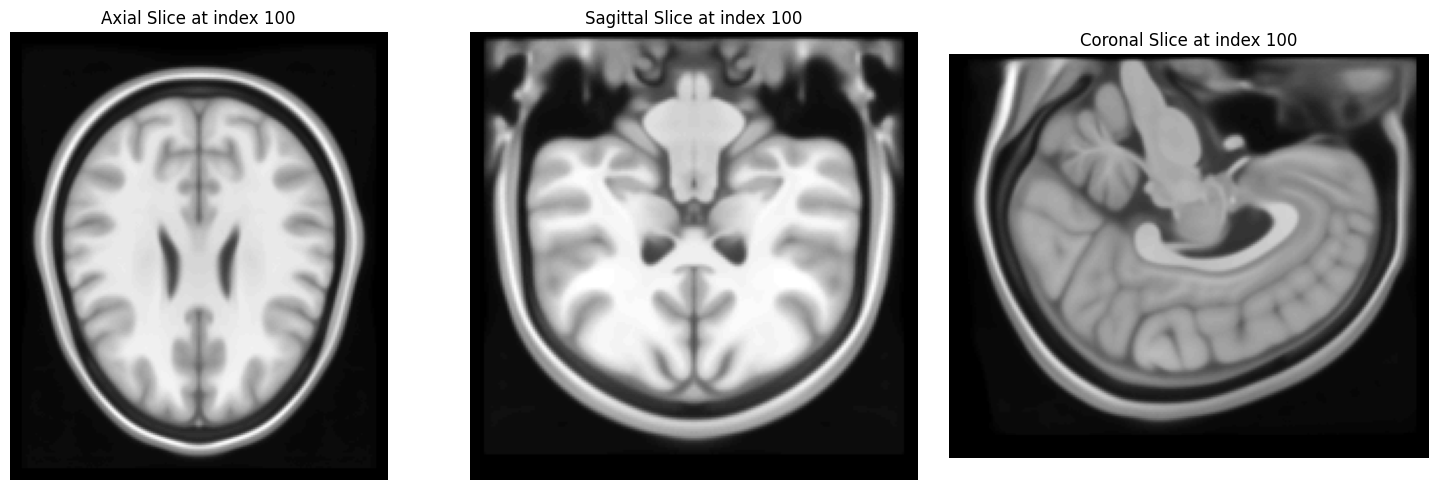

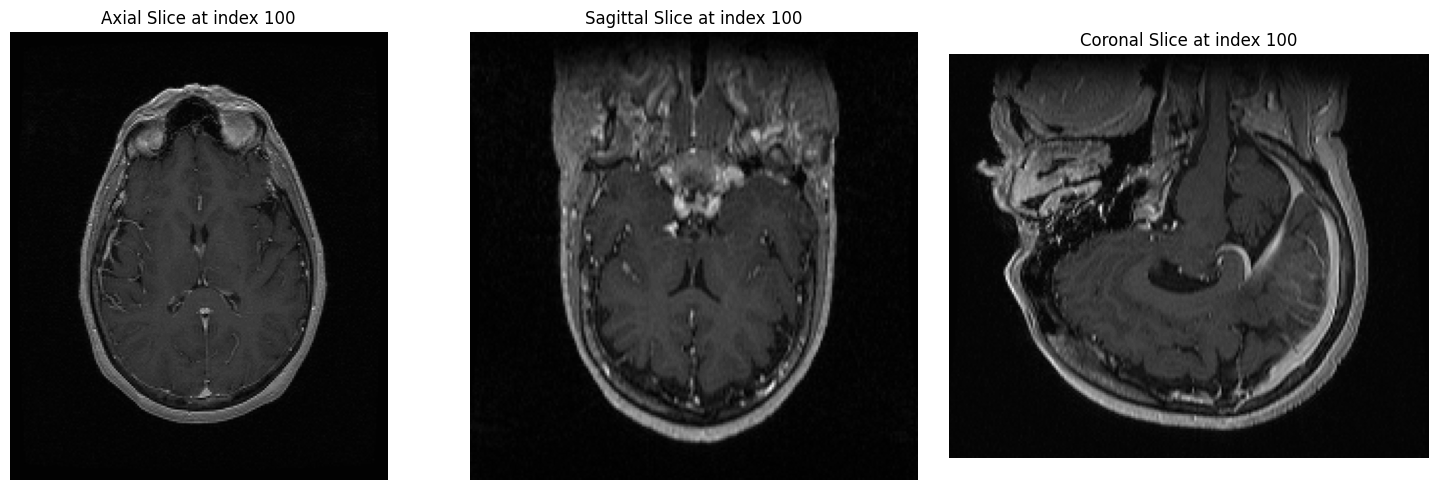

In [15]:
visualize_slices(reference_image.pixel_array, 100, 100, 100)
patient_image.visualize_slices(100, 100, 100)

In [16]:
print(patient_image.pixel_array.shape)
print(reference_image.pixel_array.shape)

(193, 229, 193)
(193, 229, 193)


## Coregistraion

In [34]:
def rigid_transformation(image, parameters):

    t1, t2, t3, angle1, angle2, angle3 = parameters

    translated_image = np.roll(image, parameters[0:3].astype(int), axis=(0, 1, 2))
    image = scipy.ndimage.rotate(image, (180/np.pi) * angle1, axes=(1, 2), reshape=False)
    image = scipy.ndimage.rotate(image, (180/np.pi) * angle2, axes=(0, 2), reshape=False)
    image = scipy.ndimage.rotate(image, (180/np.pi) * angle3, axes=(0, 1), reshape=False)

    return image

In [35]:
def mse(ref_img, inp_img):
    return np.mean(((ref_img-inp_img))**2)

def normalize(input_array):
    min_val = np.min(input_array)
    max_val = np.max(input_array)

    # Perform min-max normalization
    normalized_array = (input_array - min_val) / (max_val - min_val)
    return normalized_array

def find_centroid_volume(volume):
    idcs = np.where(volume != 0)
    centroid = np.stack([
        np.mean(idcs[0]),
        np.mean(idcs[1]),
        np.mean(idcs[2]),
    ])
    return centroid

In [19]:
def coregister_image(ref_image: np.ndarray, inp_image: np.ndarray, optimizer="GD"):
    """ Coregister two sets of landmarks using a rigid transformation. """

    errors = []

    center_ref = find_centroid_volume(ref_image)
    center_inp = find_centroid_volume(inp_image)

    translation_vector = center_inp - center_ref

    initial_parameters = [
        translation_vector[0], translation_vector[1], translation_vector[2],    # Translation vector
        np.pi, 0, 0         # In radians
    ]

    def function_to_minimize(parameters):
        input_image = reference_image(inp_image, parameters)
        error = mse(ref_image, input_image)
        errors.append(error)
        return error


    if optimizer == "GD":
        # Apply gradient descent optimization
        result = minimize(
            function_to_minimize,
            x0=initial_parameters)
    else:
        # Apply least squares optimization
        print( initial_parameters)
        result = least_squares(
            function_to_minimize,
            x0=initial_parameters,
            max_nfev=50,
            verbose=2)
    return result, errors

In [20]:
# least squares
result, errors = coregister_image(normalize(reference_image.pixel_array), normalize(patient_image.pixel_array), "LS")

[5.439242650282878, -1.6422515392396093, 0.0006077400835380331, 3.141592653589793, 0, 0]
`ftol` termination condition is satisfied.
Function evaluations 27, initial cost 1.7008e-03, final cost 1.6974e-03, first-order optimality 2.54e-05.


In [21]:
result.x

array([ 5.43924265e+00, -1.64225154e+00,  6.07740084e-04,  3.14159265e+00,
        0.00000000e+00,  1.01510763e-02])

In [30]:
parameters = [5.439242650282878, -1.6422515392396093, 0.0006077400835380331, 3.141592653589793, 0, 0]

In [32]:
transformed = rigid_transform(patient_image.pixel_array, parameters)

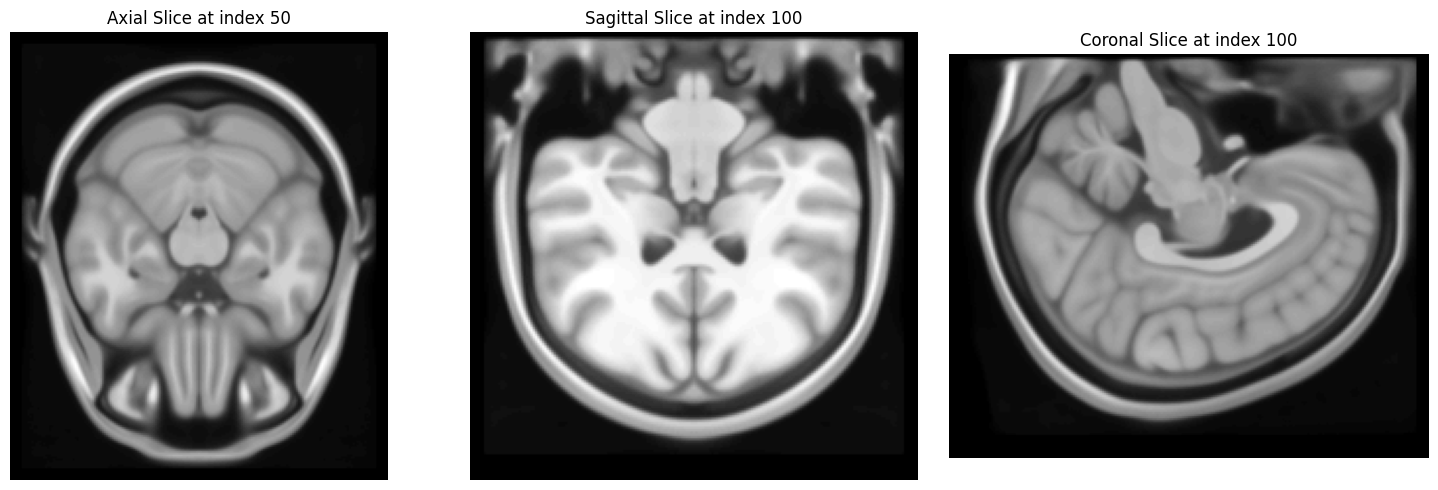

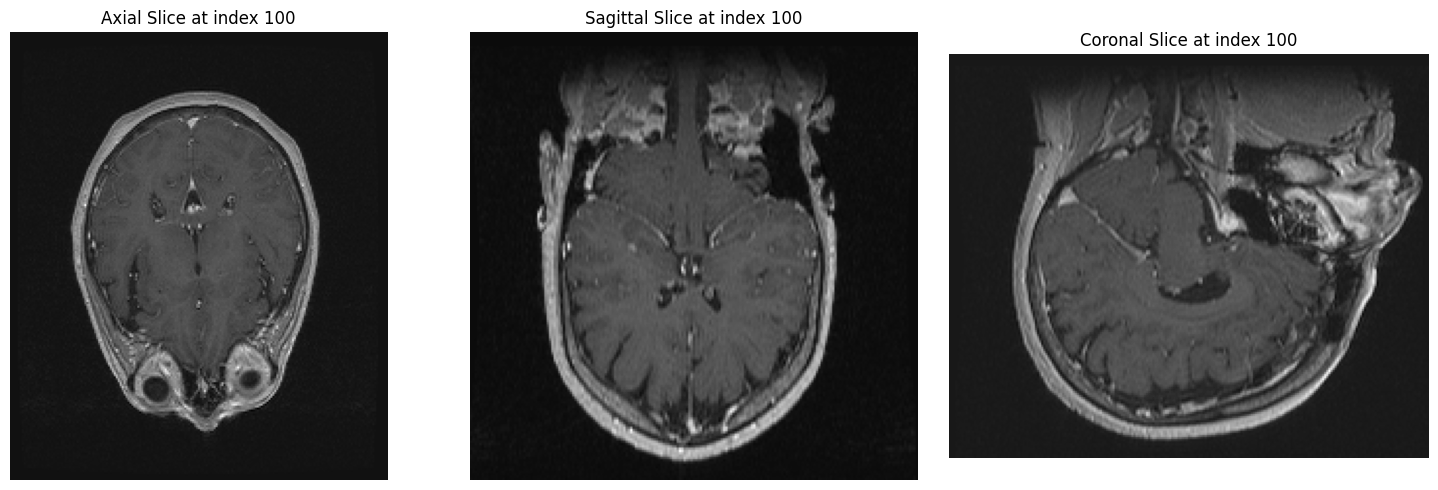

In [33]:
visualize_slices(reference_image.pixel_array, 50, 100, 100)
visualize_slices(transformed, 100, 100, 100)

## Thalamus Region